# SINGLE IMAGE SUPER RESOLUTION

### Import Libraries

In [1]:
import os
import re
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow as tf
print(tf.__version__)

2.1.0


## Task 2: What are Autoencoders?

<img src="images/autoencoder.jpg">

In [2]:
input_img = Input(shape=(256,256,3))
l1 = Conv2D(64,(3,3), padding='same', activation='relu',
           activity_regularizer=regularizers.l1(10e-10))(input_img)
l2=Conv2D(64,(3,3), padding='same', activation='relu',
           activity_regularizer=regularizers.l1(10e-10))(l1)
l3=MaxPooling2D(padding='same')(l2)
l4=Conv2D(128,(3,3), padding='same', activation='relu',
           activity_regularizer=regularizers.l1(10e-10))(l3)
l5=Conv2D(128,(3,3), padding='same', activation='relu',
           activity_regularizer=regularizers.l1(10e-10))(l4)
l6=MaxPooling2D(padding='same')(l5)
l7 = Conv2D(256,(3,3), padding='same', activation='relu',
           activity_regularizer=regularizers.l1(10e-10))(l6)

In [3]:
l8 = UpSampling2D()(l7)
l9 = Conv2D(128,(3,3),padding='same',activation='relu',
           activity_regularizer=regularizers.l1(10e-10))(l8)
l10 = Conv2D(128,(3,3),padding='same',activation='relu',
           activity_regularizer=regularizers.l1(10e-10))(l9)
l11 = add([l5,l10])
l12=UpSampling2D()(l11)
l13 = Conv2D(64,(3,3),padding='same',activation='relu',
           activity_regularizer=regularizers.l1(10e-10))(l12)
l14 = Conv2D(64,(3,3),padding='same',activation='relu',
           activity_regularizer=regularizers.l1(10e-10))(l13)
l15=add([l14,l2])
decoded = Conv2D(3,(3,3),padding='same',activation='relu',
           activity_regularizer=regularizers.l1(10e-10))(l15)
autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [4]:
autoencoder.compile(optimizer='adadelta',loss='mean_squared_error')

In [5]:
# tf.keras.utils.plot_model( autoencoder, to_file='model.png')

## Create Dataset and Train

In [18]:

from skimage.transform import resize, rescale
from cv2 import resize as rs



def train_batches(just_load_dataset=True):

    batches = 29 # Number of images to have at the same time in a batch

    batch = 0 # Number if images in the current batch (grows over time and then resets for each batch)
    batch_nb = 0 # Batch current index

    max_batches = 8 # If you want to train only on a limited number of images to finish the training even faster.
    
    ep = 10 # Number of epochs

    images = []
    x_train_n = []
    x_train_down = []
    
    x_train_n2 = [] # Resulting high res dataset
    x_train_down2 = [] # Resulting low res dataset
    data_path = r"C:\data\cars_train"
    for root, dirnames, filenames in os.walk(data_path):
        for filename in filenames:
            if re.search("\.(jpg|jpeg|JPEG|png|bmp|tiff)$", filename):
                if batch_nb == max_batches: # If we limit the number of batches, just return earlier
                    return x_train_n2, x_train_down2
                filepath = os.path.join(root, filename)
                image = pyplot.imread(filepath)
                if len(image.shape) > 2:
                        
                    image_resized = resize(image, (256, 256)) # Resize the image so that every image is the same size
                    x_train_n.append(image_resized) # Add this image to the high res dataset
                    x_train_down.append(np.array(rs(rs(image_resized, (128,128)), (256,256)))) # Rescale it 0.5x and 2x so that it is a low res image but still has 256x256 resolution

#                     print(batch)

                    batch += 1
                    if batch == batches:
                        batch_nb += 1

                        x_train_n2 = np.array(x_train_n)
                        x_train_down2 = np.array(x_train_down)

                        if just_load_dataset:
                            return x_train_n2, x_train_down2
                        
                        print('Training batch', batch_nb, '(', batches, ')')

                        autoencoder.fit(x_train_down2, x_train_n2,
                            epochs=ep,
                            batch_size=10,
                            shuffle=True,
                            validation_split=0.15)
                    
                        x_train_n = []
                        x_train_down = []
                    
                        batch = 0

    return x_train_n2, x_train_down2

## Load the Dataset 

In [7]:
x_train_n , x_train_down = train_batches(just_load_dataset=True)

In [19]:
# x_train_n[0]
path_to_data = r'C:\data\weights_best.hdf5'

In [17]:
autoencoder.load_weights(path_to_data)

## Predict and Visualize the Results

In [10]:
sr1 = np.clip(autoencoder.predict(x_train_down),0.0,1.0)

In [11]:
image_index  = np.random.randint(0,28)

Text(0.5, 1.0, 'High res output')

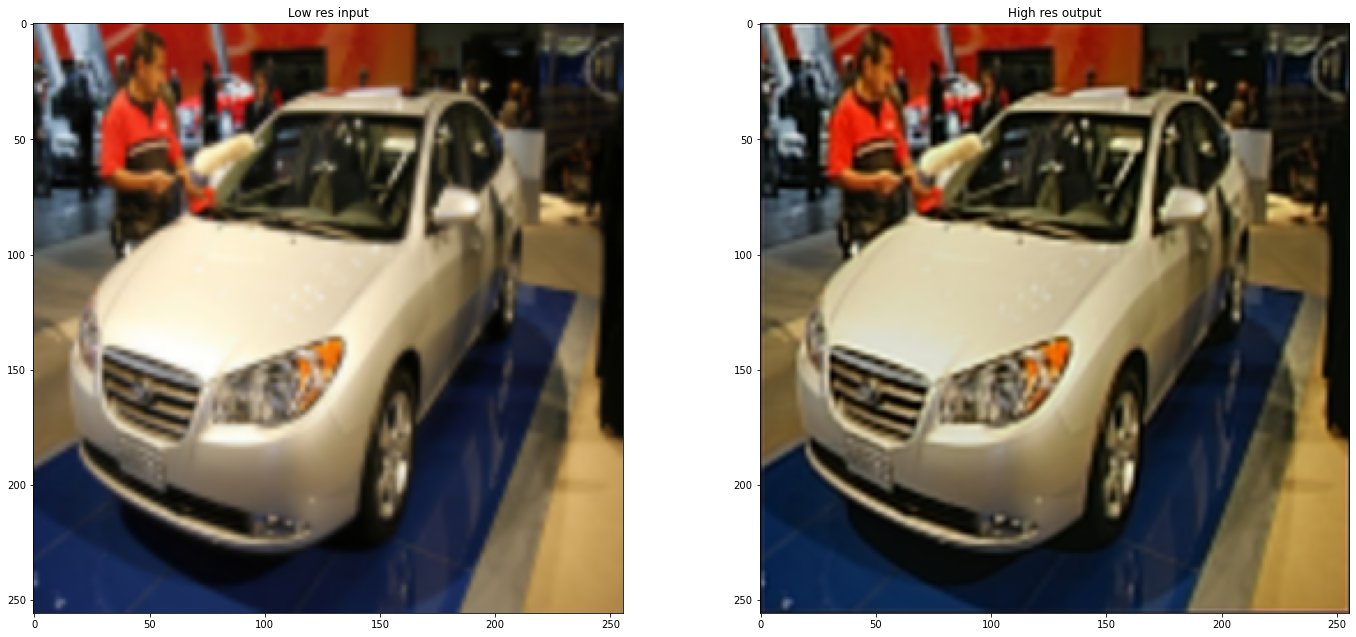

In [12]:
plt.figure(figsize=(128,128))
i=1
ax=plt.subplot(10,10,i)
plt.imshow(x_train_down[image_index])
i+=1
plt.title('Low res input')
ax=plt.subplot(10,10,i)
plt.imshow(sr1[image_index])
plt.title('High res output')